In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader

from captum.attr import Saliency

from seaborn import heatmap

In [3]:
close_file = np.load('../data/new/raw/close_84.npy') 
open_file  = np.load('../data/new/raw/open_84.npy')

noised_close = np.load('../data/new/raw/noised_close.npy')
noised_open  = np.load('../data/new/raw/noised_open.npy')

In [4]:
full_dataset = OpenCloseDataset(datafolder='../data/new', 
                                open_file=open_file, close_file=close_file, 
                                reload=True, k_degree=None, 
                                noise_n=25, noise_close=noised_close, noise_open=noised_open)

Processing...
Done!


In [6]:
full_dataset[4]

Data(x=[422, 422], edge_index=[2, 5688], edge_attr=[5688], y=1)

In [57]:
test_idx = np.random.choice(np.arange(84*2, dtype=int), 20).tolist()
train_idx = np.delete(np.arange(len(full_dataset)), test_idx).tolist()
test_dataset = full_dataset[test_idx[:10]]
train_dataset = full_dataset[train_idx]
val_dataset = full_dataset[test_idx[10:]]

In [58]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [59]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.5).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


58594

In [16]:
model.load_state_dict(torch.load('..\weights\gcn_128_32_05_acc_09.pt', map_location='cuda:0'))

<All keys matched successfully>

In [60]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='../weights/gcn_128_32_05.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0697, Test Loss 0.1230, Train Acc: 0.8483, Test Acc: 0.8125
Test precision: 0.8333, Test recall: 0.7500
Epoch: 002, Train Loss: 0.0418, Test Loss 0.1099, Train Acc: 0.9600, Test Acc: 0.6250
Test precision: 0.6500, Test recall: 0.9000
Epoch: 003, Train Loss: 0.0272, Test Loss 0.0613, Train Acc: 0.9800, Test Acc: 0.8125
Test precision: 0.8333, Test recall: 0.9000
Epoch: 004, Train Loss: 0.0168, Test Loss 0.0619, Train Acc: 0.9950, Test Acc: 0.8750
Test precision: 0.9000, Test recall: 0.9000
Epoch: 005, Train Loss: 0.0098, Test Loss 0.0533, Train Acc: 1.0000, Test Acc: 0.8750
Test precision: 0.8750, Test recall: 0.8750
Epoch: 006, Train Loss: 0.0054, Test Loss 0.0512, Train Acc: 1.0000, Test Acc: 0.8750
Test precision: 0.8750, Test recall: 0.8750
Epoch: 007, Train Loss: 0.0036, Test Loss 0.0571, Train Acc: 1.0000, Test Acc: 0.8750
Test precision: 0.4167, Test recall: 0.4167
Epoch: 008, Train Loss: 0.0023, Test Loss 0.0556, Train Acc: 1.0000, Test Acc: 0.8750
Test

In [61]:
test_loader = DataLoader(test_dataset)
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(0.5506059100385755, 0.5, 0.3, 0.3)

In [13]:
[i for i, en in enumerate(test_dataset) if en.y == 1]

[1, 4, 5, 6, 7, 8, 9]

In [19]:
from captum.attr import Saliency, IntegratedGradients
from torch import exp

model.to('cpu')

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to('cpu')
    out = model(data.x, data.edge_index, edge_mask, batch)
    return out


def explain(method, data, target=0):
    data.to('cpu')
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to('cpu')
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask


idx = 0
edge_mask = explain(method='saliency', data=test_dataset[idx], target=test_dataset[idx].y)

In [20]:
from collections import defaultdict
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

edge_dict = aggregate_edge_directions(edge_mask, test_dataset[0])

In [35]:
matr = np.zeros((422, 422))
for k in edge_dict:
    matr[k[0], k[1]] = edge_dict[k]


<AxesSubplot:>

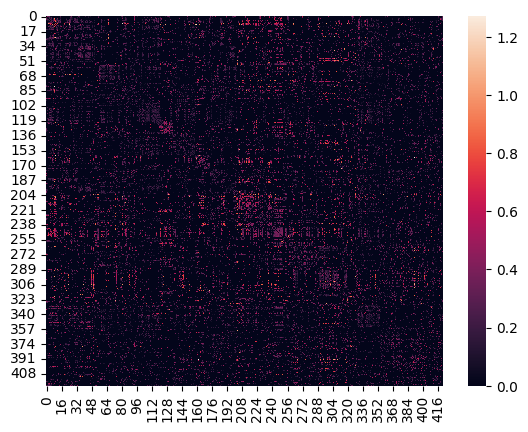

In [39]:
heatmap(np.where(matr,matr,matr.T))

In [40]:
idx = 0
edge_mask_ig = explain(method='ig', data=test_dataset[idx], target=test_dataset[idx].y)
edge_dict_ig = aggregate_edge_directions(edge_mask_ig, test_dataset[0])

<AxesSubplot:>

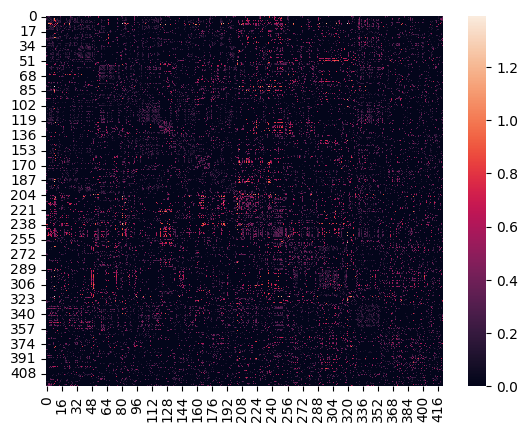

In [42]:
matr_ig = np.zeros((422, 422))
for k in edge_dict:
    matr_ig[k[0], k[1]] = edge_dict_ig[k]

heatmap(np.where(matr_ig, matr_ig, matr_ig.T))


to_captum_model

Converts a model to a model that can be used for Captum attribution methods.

to_captum_input

Given x, edge_index and mask_type, converts it to a format to use in Captum attribution methods.

captum_output_to_dicts

Convert the output of Captum attribution methods which is a tuple of attributions to two dictionaries with node and edge attribution tensors.

In [18]:
idx = 6
# test_dataset[idx].x.requires_grad_()
print(test_dataset[idx].y.item())
input_mask = torch.ones(test_dataset[idx].edge_index.shape[1]).requires_grad_(True).to('cpu')
sal = Saliency(model.to('cpu'))
mask = sal.attribute(input_mask,  #test_dataset[idx].x.requires_grad_(), 
                     additional_forward_args=(test_dataset[idx].edge_index, test_dataset[idx].edge_attr, test_dataset[idx].batch),
                     target=test_dataset[idx].y)

edge_mask = np.abs(mask.cpu().detach().numpy())
if edge_mask.max() > 0:  # avoid division by zero
    edge_mask = edge_mask / edge_mask.max()

heatmap(edge_mask);

1


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

In [5]:
import pandas as pd

hcp = pd.read_excel('../data/HCPex_sorted.xlsx')
hcp.drop([256, 257, 258, 259], inplace=True)


In [6]:
hcp.head()

,Index,ID,Label,Cortical Division,R,G,B,X,Y,Z
0,0,1,Primary_Visual_Cortex_L,Primary_Visual,208,216,117,-10.078,-84.159,1.759
1,1,181,Primary_Visual_Cortex_R,Primary_Visual,208,216,117,-12.044,-82.059,4.029
2,2,2,Second_Visual_Area_L,Early_Visual,231,50,224,-16.607,-84.793,7.259
3,3,182,Second_Visual_Area_R,Early_Visual,231,50,224,-29.556,-86.009,-1.542
4,4,3,Third_Visual_Area_L,Early_Visual,33,58,133,-24.456,-74.776,38.047


In [ ]:
salient_connections = np.zeros((422, 422))
for i in range(422):
    salient_connections[i] = edge_mask[i] > 0.6

ValueError: 'adjacency_matrix' is supposed to have shape (n, n). Its shape was (422,)

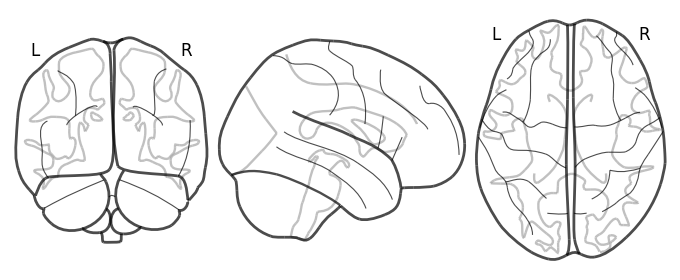

In [44]:
from nilearn.plotting import plot_connectome

plot_connectome(matr[0], hcp[['X', 'Y', 'Z']].values);

positional encoding

In [16]:
coords = hcp[['X', 'Y', 'Z']].values

coords.shape

(422, 3)

In [27]:
coords_reshaped = coords.reshape((1, 3, 422))[:, :, np.newaxis, np.newaxis, :].copy()

In [19]:
import torch
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,6,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)
print(penc_no_sum + x == penc_sum) # True

tensor([[[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True]]])


In [22]:
torch.zeros((1,3,1,1,422))

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.]]]]])

In [29]:
p_enc_3d = PositionalEncoding3D(422)
p_enc_3d(torch.from_numpy(coords_reshaped))

tensor([[[[[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000]]],


         [[[ 0.8415,  0.5403,  0.7697,  ...,  1.0000,  0.0000,  1.0000]]],


         [[[ 0.9093, -0.4161,  0.9828,  ...,  1.0000,  0.0000,  1.0000]]]]],
       dtype=torch.float64)

In [21]:
z

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
 

In [7]:
p_enc_1d_model

PositionalEncoding1D()